In [1]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")
library(umap)
# setwd("/projects/CARDIPS/analysis/epigenome_resource/")
theme_bw2 = theme_bw() +
    theme(
        axis.text = element_text(size = 12),
        strip.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.position = "top"
    )

In [2]:
gene_info = fread("/reference/private/Gencode.v44lift38/gene_info.txt",sep="\t",data.table=F)

ipsc_exp_path="path/to/ipsc/expression"
cvpc_exp_path="path/to/cvpc/expression"
ppc_exp_path="path/to/ppc/expression"

ipsc_exp_path="/projects/CARDIPS/analysis/epigenome_resource/eqtls/iPSC/input/phenotype_tpm_matrix.txt"
cvpc_exp_path="/projects/CARDIPS/analysis/epigenome_resource/eqtls/CVPC/input/phenotype_tpm_matrix.txt"
ppc_exp_path="/projects/CARDIPS/analysis/epigenome_resource/eqtls/PPC/input/phenotype_tpm_matrix.txt"

ipsc_exp = fread(ipsc_exp_path,sep="\t",data.table=F)
cvpc_exp = fread(cvpc_exp_path,sep="\t",data.table=F)
ppc_exp  = fread(ppc_exp_path,sep="\t",data.table=F)

In [3]:
all_enrich = fread("~/projects/Resource/iPSCORE_Multi-QTL_Resource/SourceData/SOURCEDATA.FIGURE2A.txt",sep="\t",data.table=F)

all_enrich$Tissue = factor(all_enrich$Tissue, levels = c("iPSC","CVPC","PPC"))


tf_toplot = all_enrich %>% filter(Database == "JASPAR" | TF == "NANOG")

tf_toplot = tf_toplot[ tf_toplot$TF %in% c("MEIS2","MEF2C","SOX2","POU5F1","ONECUT1","NKX2-5","NANOG","PDX1","NKX6-1","HNF1B","GATA4","CTCF","EGR1","E2F2","E2F5",
                                                "SOX9","Pou5f1Sox2","E2F4","E2F3","E2F1","MEIS1","TGIF2","MEIS1var.2","KLF3","SP9","YY2","POU2F1","CTCFL"),]
tf_toplot$Significance = ifelse(tf_toplot$AdjustedPvalue < 5e-10, "***",
                                  ifelse(tf_toplot$AdjustedPvalue < 5e-3, "**",
                                         ifelse(tf_toplot$AdjustedPvalue < 0.05, "*", "")))
tf_toplot$`log2(OR)` = log2(tf_toplot$OddsRatio)

tf_toplot$`log2(OR)`[ tf_toplot$`log2(OR)` < -2.5 ] = -2.5
tf_toplot$`log2(OR)`[ tf_toplot$`log2(OR)` > 2.5 ] = 2.5
tf_toplot$Tissue = factor(tf_toplot$Tissue , levels = c("iPSC","CVPC","PPC","Shared"))

cast = reshape2::dcast(Tissue ~ TF, data = tf_toplot, fun.aggregate = mean, value.var = "log2(OR)")
rownames(cast) = cast$Tissue
cast$Tissue = NULL

ord = hclust( dist(t(cast), method = "euclidean"), method = "ward.D" )$order

tf_toplot$TF = factor(tf_toplot$TF, levels = rev(colnames(cast[,ord])))

In [4]:
exp_tfs = unique(tf_toplot$TF)
exp_tfs = gsub("var.2","",exp_tfs)

genes2plot = gene_info[ gene_info$gene_name %in% exp_tfs , ]

melt_genes = function(exp_mat, tissue) {
    filt_mat = exp_mat[ exp_mat$V1 %in% genes2plot$gene_id, ]
    melt_filt = melt(filt_mat)
    colnames(melt_filt) = c("gene_id","sample_id","TPM")
    melt_filt2 = merge(melt_filt,genes2plot[,c("gene_name","gene_id")])
    melt_filt2$Tissue = tissue
    return(melt_filt2)
}

melted = rbind(rbind(melt_genes(ipsc_exp, "iPSC"),melt_genes(cvpc_exp, "CVPC")),melt_genes(ppc_exp, "PPC"))

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(filt_mat). In the next version, this warning will become an error.”
Using V1 as id variables

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(filt_mat). In the next version, this warning will become an error.”
Using V1 as id variables

Warn

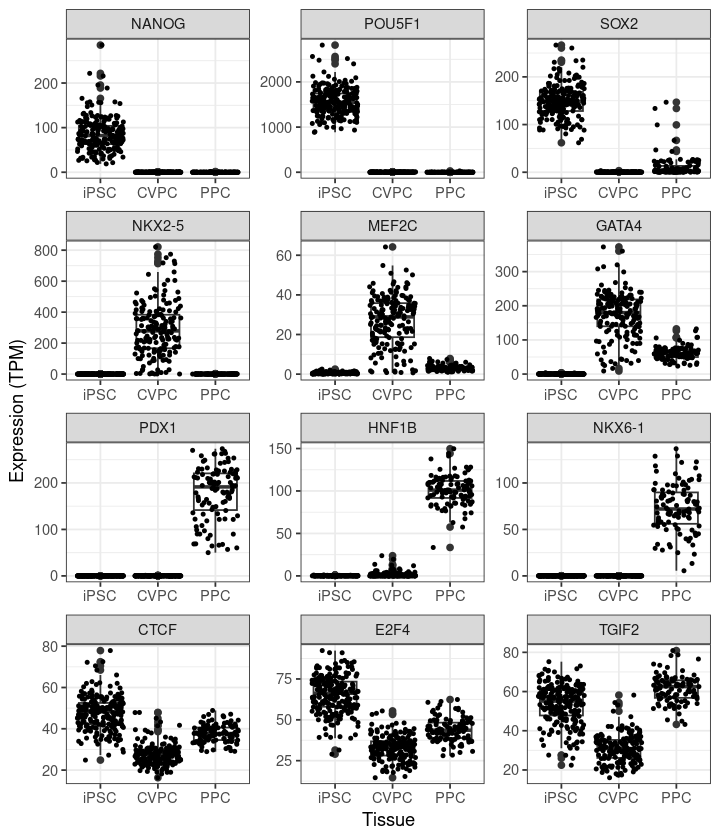

In [5]:
psize(7,6)
gene_factors = c("NANOG","POU5F1","SOX2",
                "NKX2-5","MEF2C","GATA4",
                "PDX1","HNF1B","NKX6-1",
                "CTCF","E2F4","TGIF2")
melted2 = melted[ melted$gene_name %in% gene_factors, ]
melted2$Gene = factor(melted2$gene_name, levels = gene_factors)
melted2$Tissue = factor(melted2$Tissue, levels = c("iPSC","CVPC","PPC"))
# png("supplementalfigures/figure_s5.png",units="in",res=300, height=7,width=6)
ggplot(melted2, aes(Tissue, TPM, group=Tissue)) + theme_bw() + 
            ylab("Expression (TPM)") +
            geom_boxplot() + geom_jitter(size=0.75) + 
            facet_wrap(~Gene, scales='free', nrow=4)
# dev.off()